In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from autograd import grad, hessian, jacobian

In [2]:
from functions.ellipsoid import Ellipsoid
from functions.rosenbrock import Rosenbrock
from functions.log_ellipsoid import LogEllipsoid
from functions.attractive_sector import AttractiveSector
from functions.sum_of_different_powers import SumOfDifferentPowers

In [15]:
from scipy.optimize import line_search

def backtrack(f, x, p, f_grad, a_bar=10, rho=0.5, c=0.0001):
    a = a_bar
    iterations = 0
    while f(x + a*p) > f(x) + c * a * (np.array(f_grad(x)).T @ p):
        a = rho * a
        iterations += 1
        assert iterations < 1000
    return a, iterations

class QuasiNewtonLineSearch:
    @staticmethod
    def get_label():
        return 'Quasi-Newton Line Search'

    @staticmethod
    def minimize(
            f,
            x0,
            der,
            max_iterations=10000,
            callback=None,
            initial_alpha=0.1,
            initial_inv_hessian=None,
            c1=1e-4, c2=0.9,
            hes=None
    ):
        x = np.array(x0)
        alpha = initial_alpha
        inv_hessian = initial_inv_hessian
        if inv_hessian is None:
            inv_hessian = np.linalg.inv(np.eye(len(x0)))

        for k in range(max_iterations):
            p_k = -inv_hessian @ der(x)
            p_k_scale_factor, _ = backtrack(f, x, p_k, der)
            p_k = p_k * p_k_scale_factor

            alpha, _, _, new_f_val, old_f_val, new_slope = line_search(f, der, x, p_k, c1=c1, c2=c2)
            skip_update = False
            if alpha is None:
                alpha = 1.0
                skip_update = True
            
            new_x = x + alpha * p_k
            y_k = np.array(der(new_x)) - np.array(der(x))
            s_k = new_x - x
            rho_k = 1/(y_k.T @ s_k)
            I = np.eye(len(x))
            if not skip_update:
                inv_hessian = (I - rho_k * np.outer(s_k, y_k)) @ inv_hessian @ (I -
                                                             rho_k * np.outer(y_k, s_k)) + rho_k * np.outer(s_k, s_k)
            x = new_x
            if callback and callback(x):
                return x


In [4]:
def plot_contour(f, xs=10, ys=10, lines=50):
    n = 500
    x, y = np.linspace(-xs, xs, n), np.linspace(-ys, ys, n)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            Z[i][j] = f([X[i][j], Y[i][j]])
    plt.contour(X,Y,Z, lines)

In [5]:
def print_state(xk, F):
    print("-----")
    print("x: ", xk)
    print("f(x): ", F.f(xk))
    print("f_grad(x): ", F.gradient(xk))
    print("f_hess(x):", F.hessian(xk))

def print_meta_state(meta, m, latest_point):
    pass
    #print("delta for next iter", meta['delta'])
    #print("rho", meta['rho'])
    #print("p", meta['direction'])
    #print("p_norm", np.linalg.norm(meta['direction'][0]))
    #print("m", m(meta['direction'][0], latest_point))
def plot_contour_from_function(minimize, F, xs=10, ys=10, g_tol=0.1, debug=False, start_point=[8,8], max_iterations=1000, c1=1e-4, c2=0.9):
    xk_at_i = [start_point]
    if debug:
        print_state(start_point, F)

    def c(xk):
        if debug:
            print_state(xk, F)
        xk_at_i.append(xk)
        if np.linalg.norm(F.gradient(xk)) < g_tol:
            return True
        return False
    def meta_f(meta):
        if debug:
            print_meta_state(meta, m, xk_at_i[-1])
    plot_contour(F.f, xs=xs, ys=ys)
    print(minimize(F.f, start_point, grad(F.f), callback=c, max_iterations=max_iterations, c1=c1, c2=c2))
    #print([np.linalg.norm(F.gradient(xk)) for xk in xk_at_i])
    #print(xk_at_i)
    plt.plot([xk[0] for xk in xk_at_i[:-1]], [xk[1] for xk in xk_at_i[:-1]], c='orange')
    plt.scatter([xk[0] for xk in xk_at_i[:-1]], [xk[1] for xk in xk_at_i[:-1]], c='orange')

In [6]:
def get_xs(F, optimizer, starting_points = None):
    lines_xs = []
    if starting_points is None:
        starting_points = [
            [-7.0,7.0], [7.0,7.0], [3.0,6.0], [10.0,0.7], [3.0,-6.0]
        ]
    for point in starting_points:
        xs = []
        def c(xk):
            xs.append(xk)
            if np.linalg.norm(F.gradient(xk)) < 0.01:
                return True
            return False
        optimizer.minimize(F.f, np.array(point), grad(F.f), callback=c, max_iterations=100, hes=F.hessian)
        lines_xs.append(xs)
    return lines_xs

[8.97338867 0.64086914] 7.62939453125e-05
[ 0.38253859 -4.78012859] 0.0048828125
[-0.21842376  2.50747977] 1.25
[ 0.05823317 -0.71597669] 1.25
[-0.01313947  0.15646225] 1.25
[ 0.00325373 -0.04099348] 1.25
[-0.00093439  0.00958547] 1.25
[ 9.49022116e-05 -2.86934362e-03] 1.25
[-0.00127528 -0.00368385] 10
[-0.04527148 -0.16822584] 5.0
[-0.01425888 -0.10366062] 5.0
[-0.28924098 -1.18493899] 5.0
[-0.17843841 -0.69449543] 1.25
[-0.3121944  -1.05781392] 2.5
[0.01755274 0.09891353] 0.3125
[-0.15545992 -0.50179068] 2.5
[-0.06684175 -0.20349596] 0.625
[-0.0671682  -0.14159966] 5.0
[-0.08915942 -0.25292365] 0.625
[-0.05002699 -0.13320488] 0.625
[-0.09973904 -0.23845459] 5.0
[0.00984988 0.04195049] 1.25
[-0.04353115 -0.104507  ] 1.25
[-0.06477    -0.14133338] 2.5
[-0.04407078 -0.0828502 ] 2.5
[-0.01314853 -0.02907403] 0.625
[0.01387633 0.02801804] 2.5
[-0.00700528 -0.01439738] 1.25
[-8.9730835   0.64086914] 7.62939453125e-05
[-0.38253648 -4.77997307] 0.0048828125
[0.21862067 2.50625067] 1.25
[-0.0

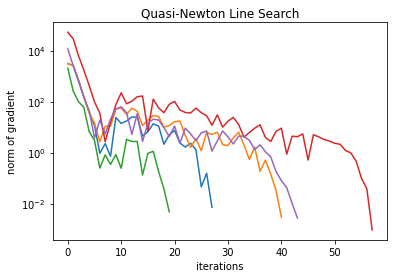

In [7]:
F = Rosenbrock
optimizer = QuasiNewtonLineSearch
xs_lines = get_xs(F, optimizer)
for line in xs_lines:
    #print([np.linalg.norm(F.gradient(xk)) for xk in line])
    plt.yscale('log')
    plt.ylabel('norm of gradient')
    plt.xlabel('iterations')
    plt.title(optimizer.get_label())
    plt.plot([np.linalg.norm(F.gradient(xk)) for xk in line])

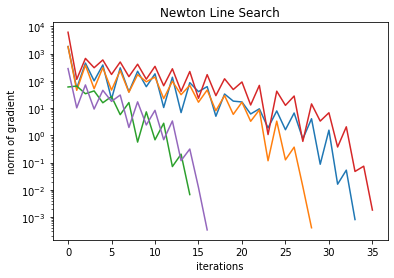

In [8]:
from optimizers.line_search.newton import NewtonLineSearch
F = Rosenbrock
optimizer = NewtonLineSearch
xs_lines = get_xs(F, optimizer)
for line in xs_lines:
    #print([np.linalg.norm(F.gradient(xk)) for xk in line])
    plt.yscale('log')
    plt.ylabel('norm of gradient')
    plt.xlabel('iterations')
    plt.title(optimizer.get_label())
    plt.plot([np.linalg.norm(F.gradient(xk)) for xk in line])

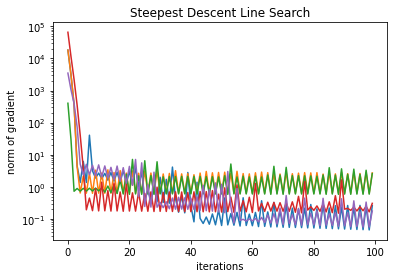

In [9]:
from optimizers.line_search.steepest_descent import SteepestDescentLineSearch
F = Rosenbrock
optimizer = SteepestDescentLineSearch
xs_lines = get_xs(F, optimizer)
for line in xs_lines:
    #print([np.linalg.norm(F.gradient(xk)) for xk in line])
    plt.yscale('log')
    plt.ylabel('norm of gradient')
    plt.xlabel('iterations')
    plt.title(optimizer.get_label())
    plt.plot([np.linalg.norm(F.gradient(xk)) for xk in line])

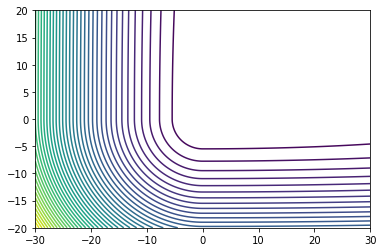

In [ ]:
plot_contour_from_function(QuasiNewtonLineSearch.minimize, AttractiveSector, start_point=[12.0, 10.0], xs=30, ys=20)

ERROR! Session/line number was not unique in database. History logging moved to new session 470
[-0.02621694 -2.99747015] 0.0021847450052839253
[-9.52606267 -0.54952441] 0.7976644307687251
[ 4.80757209 -1.45835136] 1.853020188851841
[-1.99810205 -0.6215597 ] 1.853020188851841
[ 0.95589517 -0.5124289 ] 2.05891132094649
[-0.3041187  -0.33810102] 2.2876792454961
[ 0.12804635 -0.18249639] 2.05891132094649
[-0.04982751 -0.13725326] 2.2876792454961
[-0.01281427  0.20281481]


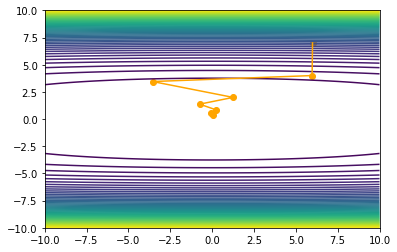

In [14]:
plot_contour_from_function(QuasiNewtonLineSearch.minimize, SumOfDifferentPowers, start_point=[6.0, 7.0])

In [11]:
from scipy.optimize import line_search
from autograd import grad

def backtrack(f, x, p, f_grad, a_bar=10, rho=0.9, c=0.5):
    a = a_bar
    iterations = 0
    while f(x + a*p) > f(x) + c * a * (np.array(f_grad(x)).T @ p):
        a = rho * a
        iterations += 1
        assert iterations < 100000
    return a, iterations

F = Ellipsoid
x_init = np.array([-7.0, 7.0])
#H = np.linalg.inv(Rosenbrock.hessian(x_init))
B = np.eye(len(x_init)) * np.linalg.norm(x_init)**2
H = np.linalg.inv(B)
x_prime = x_init+np.ones(x_init.shape)
p_init = -H @ grad(F.f)(x_init)
line_search(F.f, grad(F.f), x_init, p_init)

(0.04900004895099996,
 5,
 1,
 48.90204895109796,
 49049.0,
 array([-1.3986e+01, -1.3986e-02]))

[-2.95431271  0.          0.        ] 0.9847709021836112
[-0.04499152  0.          0.        ] 0.9847709021836112
[-1.9695418  0.         0.       ] 0.9847709021836112
[-0.02999434  0.          0.        ] 0.9847709021836112
[2.95431271 0.         0.        ] 0.9847709021836112
[0.04499152 0.         0.        ] 0.9847709021836112
ERROR! Session/line number was not unique in database. History logging moved to new session 469


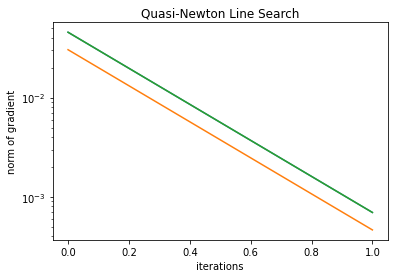

In [13]:
class QuadraticFunction:
    def __init__(self, hes):
        self.Q = hes
    
    def f(self, x):
        return 0.5 * x.T @ self.Q @ x
    
    def gradient(self, x):
        return self.Q @ x
    
    def hessian(self, x):
        return self.Q
    
hessian = np.array([[1, 0, 0], [0, 0, 0],[0,0, 0]])
starting_points = [
    [3,4,5],
    [2,3,6],
    [-3,4,-2]
]
F = QuadraticFunction(hessian)
optimizer = QuasiNewtonLineSearch
xs_lines = get_xs(F, optimizer, starting_points=starting_points)
for line in xs_lines:
    #print([np.linalg.norm(F.gradient(xk)) for xk in line])
    plt.yscale('log')
    plt.ylabel('norm of gradient')
    plt.xlabel('iterations')
    plt.title(optimizer.get_label())
    plt.plot([np.linalg.norm(F.gradient(xk)) for xk in line])